In [48]:
import numpy as np
import GPy

from mcmcGP import BinnedPoisson, GPMCMC, SGPMCMC, HMC
from jug import TaskGenerator as TG

def load_rouses():
    data = np.genfromtxt('rouses_prod97725_store57.csv',delimiter=',',names = True,usecols=(3,4,5,6), \
    dtype=[('SalesDate','S10'),('Quantity',np.float),('Revenue',np.float),('TotalCost',np.float)])

    dates = np.arange(0,len(data['SalesDate'])) # integer weeks
    Q = data['Quantity']
    rev = data['Revenue']
    cost = data['TotalCost']
    price = rev/cost
    X = np.vstack((dates,price)).T
    Y = Q
    return X,Y

#@TG
def build_vb(bin_mids, counts, num_inducing, seed):
    np.random.seed(seed)

    # grid Z
    Z = np.linspace(bin_mids.min(), bin_mids.max(), num_inducing).reshape(-1,1)

    lik = BinnedPoisson(np.diff(bin_mids.flat)[0])
    kern = GPy.kern.Matern52(1, lengthscale=10.) + GPy.kern.White(1, 5) + GPy.kern.Bias(1) 

    #pr = GPy.priors.Gamma(1., .3)
    #kern.set_prior(pr)
    return GPy.core.SVGP(X=bin_mids.reshape(-1,1), Y=counts.reshape(-1,1), Z=Z, kernel=kern, likelihood=lik)

#@TG
def build_mc_sparse(bin_mids, counts, num_inducing, seed):
    # grid Z
    Z = np.linspace(bin_mids.min(), bin_mids.max(), num_inducing).reshape(-1,1)

    lik = BinnedPoisson(np.diff(bin_mids.flat)[0])
    kern = GPy.kern.Matern52(1, lengthscale=10.) + GPy.kern.White(1, 5) + GPy.kern.Bias(1)
    kern.Mat52.lengthscale.set_prior(GPy.priors.Gamma(10., 1.))
    kern.Mat52.variance.set_prior(GPy.priors.Gamma(5., 1.))
    kern.bias.variance.set_prior(GPy.priors.Gamma(1., .3))
    #kern.white.variance.fix(1e-6)

    return SGPMCMC(X=bin_mids.reshape(-1,1), Y=counts.reshape(-1,1), Z=Z, kernel=kern, likelihood=lik)

#@TG
def optimize_vb(m, max_iters=1000):
    m.kern.fix()
    m.optimize('bfgs', max_iters=100,messages=True)
    m.kern.constrain_positive()
    m.optimize('bfgs', max_iters=max_iters, messages=True)
    return m

#@TG
def init_mc_model_from_vb(m_mcmc, m_vb):
    #take the optimized vb model, and use it to init the mcmc mode
    m_mcmc.kern[:] = m_vb.kern[:]
    m_mcmc.Z[:] = m_vb.Z[:]
    m_mcmc.Z.fix()
    L = GPy.util.choleskies.flat_to_triang(m_vb.q_u_chol)[0,:,:]
    u_sample = np.dot(L, np.random.randn(m_vb.num_inducing))
    u_sample += m_vb.q_u_mean.flatten()
    L = GPy.util.linalg.jitchol(m_mcmc.kern.K(m_mcmc.Z))
    v_sample, _ = GPy.util.linalg.dtrtrs(L, u_sample)
    #v_sample = np.dot(L, np.random.randn(L.shape[0],1)) + m_vb.q_u_mean
    m_mcmc.V[:] = v_sample.reshape(-1,1)
    return m_mcmc

#@TG
def split_train_test(X, Y, seed, Ntrain, bins):
    np.random.seed(seed)
    i = np.random.permutation(X.size)
    Xtrain, Xtest = np.asarray(X[i[:Ntrain]],dtype=np.int), np.asarray(X[i[Ntrain:]],dtype=np.int)
    Xtrain = np.sort(Xtrain) # Keep temporal ordering
    Xtest = np.sort(Xtest) # Keep temporal ordering
    Ytrain = []; Ytest = []
    for k in range(1,len(bins)):
        Ytrain.append(Y[Xtrain[k-1:k]].sum())
        Ytest.append(Y[Xtest[k-1:k]].sum())
    Ytrain = np.asarray(Ytrain); Ytest = np.asarray(Ytest)
    dataset = dict(Ytrain=Ytrain, Ytest=Ytest)

    return dataset

#@TG
def run_hmc(m, N):
    def f(x):
        return (-a for a in m._objective_grads(x))
    samples, rate = HMC(f, N, Lmax=40, epsilon=0.08, x0=m.optimizer_array)
    return samples

#@TG
def get_samples_vb(m, num_samples):
    mu, var = m._raw_predict(m.X, full_cov=True)
    samples = np.random.multivariate_normal(mu.flat, var.squeeze(), num_samples).T
    return samples
#@TG
def log_predictive_density(m, fsamples, Ytest):
    pdfs = m.likelihood.pdf(fsamples, Ytest.reshape(-1,1))
    pdfs = np.mean(pdfs,1) # average the density across samples
    logpdfs = np.log(pdfs)
    return np.mean(logpdfs) # average the log density across bins

#@TG
def get_samples_mc(m, samples, numsamples):
    ms, vs = [],[]
    for s in samples:
        m.optimizer_array = s
        mui, vi = m.predict_raw(m.X, full_cov=True)
        ms.append(mui); vs.append(vi)

    samples = np.hstack([np.random.multivariate_normal(mu.flat, var, numsamples).T for mu, var in zip(ms, vs)])
    return samples


class Experiment:
    def __init__(self, seed, Ntrain,  num_grid, num_inducing, num_samples, vb_iterations):
        self.seed, self.Ntrain,  self.num_grid, self.num_inducing, num_samples = seed, Ntrain,  num_grid, num_inducing, num_samples
        np.random.seed(seed)

        #X = load_coal()
        X,Y = load_rouses()
        X = X[:,0] # Just the times
        
        bins = np.linspace(X.min(), X.max(), num_grid+1)
        bin_mids = bins[:-1]+np.diff(bins)

        self.data = split_train_test(X, Y, seed, Ntrain, bins)

        self.m_vb = build_vb(bin_mids, self.data['Ytrain'], num_inducing, seed)
        self.m_vb = optimize_vb(self.m_vb,vb_iterations)

        self.m_mc = build_mc_sparse(bin_mids, self.data['Ytrain'], num_inducing, seed)
        self.m_mc = init_mc_model_from_vb(self.m_mc, self.m_vb)

        self.m_mc.kern.Mat52.constrain(GPy.core.parameterization.transformations.Exponent())
        self.m_mc.kern.bias.constrain(GPy.core.parameterization.transformations.Exponent())
        self.samples = run_hmc(self.m_mc, num_samples)

        self.fsamples_vb = get_samples_vb(self.m_vb, 10000)
        self.log_pred_vb = log_predictive_density(self.m_vb, self.fsamples_vb, self.data['Ytest'])
        self.fsamples_mc = get_samples_mc(self.m_mc, self.samples[::2], 10)
        self.log_pred_mc = log_predictive_density(self.m_mc, self.fsamples_mc, self.data['Ytest'])


In [ ]:
num_samples = 10000
vb_iterations = 10000
M = 20
grid = 50
seed = 0
experiment = Experiment(seed, Ntrain=96, num_grid=grid, num_inducing=M, num_samples=num_samples, vb_iterations=vb_iterations)

Iteration:  100 	 Acc Rate:  0.0 %
Iteration:  200 	 Acc Rate:  0.0 %
Iteration:  300 	 Acc Rate:  0.0 %
Iteration:  400 	 Acc Rate:  0.0 %
Iteration:  500 	 Acc Rate:  0.0 %
Iteration:  600 	 Acc Rate:  0.0 %
Iteration:  700 	 Acc Rate:  0.0 %
Iteration:  800 	 Acc Rate:  0.0 %
Iteration:  900 	 Acc Rate:  0.0 %
Iteration:  1000 	 Acc Rate:  0.0 %
Iteration:  1100 	 Acc Rate:  0.0 %
Iteration:  1200 	 Acc Rate:  0.0 %
Iteration:  1300 	 Acc Rate:  0.0 %
Iteration:  1400 	 Acc Rate:  0.0 %
Iteration:  1500 	 Acc Rate:  0.0 %
Iteration:  1600 	 Acc Rate:  0.0 %
Iteration:  1700 	 Acc Rate:  0.0 %
Iteration:  1800 	 Acc Rate:  0.0 %
Iteration:  1900 	 Acc Rate:  0.0 %
Iteration:  2000 	 Acc Rate:  0.0 %
Iteration:  2100 	 Acc Rate:  0.0 %
Iteration:  2200 	 Acc Rate:  0.0 %
Iteration:  2300 	 Acc Rate:  0.0 %
Iteration:  2400 	 Acc Rate:  0.0 %
Iteration:  2500 	 Acc Rate:  0.0 %
Iteration:  2600 	 Acc Rate:  1.0 %
Iteration:  2700 	 Acc Rate:  0.0 %
Iteration:  2800 	 Acc Rate:  0.0 %
I

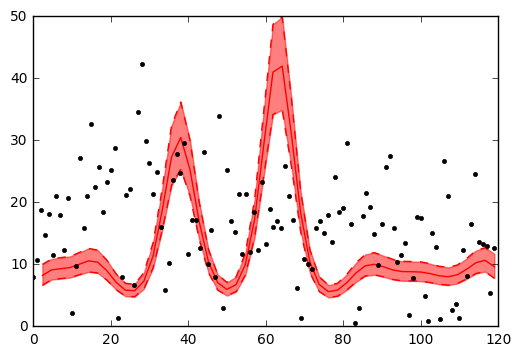

In [45]:
from matplotlib import pylab as plt

plt.figure()
X = experiment.m_vb.X
bw = experiment.m_vb.likelihood.binsize
#plt.plot(X,np.mean(np.exp(experiment.fsamples_vb)*bw,axis=1) ,'b' ,label='VB+Gaussian')
plt.plot(X,np.mean(np.exp(experiment.fsamples_mc)*bw,axis=1) ,'r' ,label='VB+MCMC')
#plt.legend()
#plt.plot(X,np.percentile(np.exp(experiment.fsamples_vb)*bw, 5,axis=1), 'b--')
#plt.plot(X,np.percentile(np.exp(experiment.fsamples_vb)*bw,95,axis=1), 'b--')
#plt.fill_between(X[:,0],np.percentile(np.exp(experiment.fsamples_vb)*bw, 5,axis=1),\
#                np.percentile(np.exp(experiment.fsamples_vb)*bw,95,axis=1),color='b',alpha=0.5)
plt.plot(X,np.percentile(np.exp(experiment.fsamples_mc)*bw, 5,axis=1), 'r--')
plt.plot(X,np.percentile(np.exp(experiment.fsamples_mc)*bw,95,axis=1), 'r--')
plt.fill_between(X[:,0],np.percentile(np.exp(experiment.fsamples_mc)*bw, 5,axis=1),\
                 np.percentile(np.exp(experiment.fsamples_mc)*bw,95,axis=1),color='r',alpha=0.5)
XR, YR = load_rouses()
XR = XR[:,0]
plt.plot(XR,YR,'k.')
plt.show()